In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
from datetime import datetime
import seaborn as sns
%matplotlib inline
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
plt.rcParams['figure.figsize'] = (10,6.180)    #golden ratio

In [2]:
def read_data(name):
#     name="tr872"
    name_list = ["Step" , "Chain" , "Shake" , "Chi" , "Rama", "Excluded", "DSSP", "P_AP", "Water" ,"Burial", "Helix", "AMH_Go", "Frag_Mem", "Vec_FM", "Membrane", "SSB","VTotal"]


    location = f"/Users/weilu/Research/server/sep_2018/03_week/02_week/{name}/"
    RMSD = pd.read_table(location+"rmsd-angstrom.xvg", names=["i", "RMSD"], sep="\s+")
    bias = pd.read_table(location+"bias.log", names=["i", "biasQ", "bias"], sep="\s+").drop("i", axis=1)
    awsem = pd.read_table(location+"awsem.log", names=name_list)
    rw = pd.read_table(location+"rwplusScore.txt", names=["i", "Rw"], sep="\s+").drop("i", axis=1)
    location = f"/Users/weilu/Research/server/sep_2018/03_week/{name}/"
    pc = pd.read_table(location+"pcarmsd_scaled.txt", names=["i", "pc", "pc2"], sep="\s+").drop("i", axis=1)
    raw_data = pd.concat([RMSD, rw, bias, awsem, pc], axis=1)
    return raw_data.assign(name=name).reset_index().rename(columns={"index":"folder"})

def choose_top(data,col="RMSD", n=5, ascending=True):
    return data.assign(chosen=pd.DataFrame.rank(data[col], ascending=ascending, method='dense')<=n)


def read_data_2(name):
#     name = "tr894"
    location = f"/Users/weilu/Research/server/sep_2018/03_week/{name}/"
    rw = pd.read_table(location+"rc_rwplus", names=["pc","rw"], sep="\s+")
    rmsd = pd.read_table(location+"rc_rmsdlowerBound", names=["pc", "rmsd"], sep="\s+")
    awsem = pd.read_table(location+"rc_awsemEne", names=["pc", "awsem"], sep="\s+")
    freeE = pd.read_table(location+"pmf3000"
                          , names=["pc", "f", "remove1", "remove2"], sep="\s+").drop(["remove1", "remove2"], axis=1)
    raw_data = freeE.merge(rw, on="pc").merge(awsem, on="pc").merge(rmsd, on="pc").assign(name=name)
    return raw_data

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
def my_transform(data, label, degree, FEATURES):

    # LABEL = "Qw"
    LABEL = label
    PolynomialDegree = degree

    num_attribs = FEATURES
    cat_attribs = [LABEL]
    num_pipeline = Pipeline([
            ('selector', DataFrameSelector(num_attribs)),
            ('std_scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=PolynomialDegree, include_bias=False))
        ])
    cat_pipeline = Pipeline([
            ('selector', DataFrameSelector(cat_attribs))
        ])

    full_pipeline = FeatureUnion(transformer_list=[
            ("num_pipeline", num_pipeline),
            ("cat_pipeline", cat_pipeline),
        ])
    return full_pipeline.fit_transform(data)

In [84]:
# folder_list = ["tr894", "tr882", "tr594", "tr898", "tr862", "tr877", "tr872", "tr885", "tr866", "tr868", "tr884", "tr895", "tr896", "tr870", "tr921", "tr922", "tr891", "tr948"]
folder_list = ["tr894", "tr882", "tr594", "tr869", "tr862", "tr877", "tr872", "tr885", "tr866", "tr868", "tr884", "tr895", "tr896", "tr870", "tr921", "tr922", "tr891", "tr948"]
# folder_list = [ "tr862", "tr877", "tr872", "tr885", "tr866", "tr868", "tr884", "tr895", "tr896", "tr870", "tr921", "tr922", "tr891", "tr948"]
# folder_list = ["tr862", "tr872", "tr885", "tr866", "tr868" , "tr895", "tr896", "tr870", "tr921", "tr891", "tr948"]
# "tr877","tr884", "tr922"
# "tr869"
data_list = []
for name in folder_list:
    tmp = read_data_2(name)
    data_list.append(tmp)
raw_data_all = pd.concat(data_list)
n = 20
raw_data_all = raw_data_all.reset_index(drop=True).groupby("name").apply(choose_top, n=n, col="rmsd").reset_index(drop=True)


# train_name_list = ["tr872", "tr885", "tr948"]
# train_name_list = ["tr862", "tr872", "tr885", "tr866", "tr868" , "tr895", "tr896", "tr870", "tr921", "tr891", "tr948"]
# train_name_list = ["tr866"]
# train_name_list = ["tr948"]
# train_name_list = ["tr894"]
# train_name_list = ["tr885"]
# train_name_list = ["tr872"]
# train_name_list = ["tr594"]
# train_name_list = ["tr894", "tr922", "tr882", "tr872"]
# train_name_list = ["tr898", "tr896", "tr894", "tr895"]
# train_name_list = ["tr868"]
train_name_list = ["tr882"]
# train_name_list = ["tr866", "tr866"]
# train_name_list = ["tr870"]
# train_name_list = ["tr891"]
raw_data = raw_data_all.reset_index(drop=True).query(f'name in {train_name_list}')

In [85]:

# FEATURES = ["eigenvalues", "entropy", "pca"]
# FEATURES = ["eigenvalues", "entropy", "diffRMSD"]
# FEATURES = ["eigenvalues", "entropy"]
FEATURES = ["f",
    'rw',
     'awsem',
#     'RMSD', # test
#      'Burial',
#      'Water',
#      'Rama',
#      'DSSP',
#      'P_AP',
#      'Helix',
#      'Frag_Mem'
               ]
# FEATURES = ["eigenvalues"]
# LABEL = "diffRMSD"
# LABEL = "RMSD"
LABEL = "rmsd"
DEGREE = 1

def pred_from_raw(a):
    data = my_transform(a, label=LABEL, degree=DEGREE, FEATURES=FEATURES)
    test_y = data[:,-1]
    test_set = data[:,:-1]
    prediceted_rmsd= clf.predict(test_set)
    return a.assign(prediceted_rmsd=prediceted_rmsd)

In [86]:
# data = my_transform(raw_data, label=LABEL, degree=DEGREE, FEATURES=FEATURES)
# data = raw_data.groupby('name').apply(my_transform, label=LABEL, degree=DEGREE, FEATURES=FEATURES)[0]
data = np.concatenate(raw_data.groupby('name').apply(my_transform, 
                                                     label=LABEL, degree=DEGREE, FEATURES=FEATURES).values)
train_y = data[:,-1]
train_set = data[:,:-1]
from sklearn import svm
# clf = svm.SVC(probability=True)
clf = LinearRegression()
clf.fit(train_set, train_y)
y_pred_svm = clf.predict(train_set)

raw_data_all = raw_data_all.reset_index(drop=True).groupby("name").apply(pred_from_raw).reset_index(drop=True)


picked_n = 1
best = raw_data_all.groupby("name").apply(choose_top, col="rmsd"
                                            , n=picked_n, ascending=True).reset_index(drop=True).query("chosen==True")
picked = raw_data_all.groupby("name").apply(choose_top, col="prediceted_rmsd"
                                            , n=picked_n, ascending=True).reset_index(drop=True).query("chosen==True")
# init = raw_data_all.query("i == 0.0")
all_results = pd.concat([best.assign(result='best'), 
                         picked.assign(result='picked')])

picked_keep = picked.copy()

In [91]:
def choose_top(data,col="RMSD", n=5, ascending=True):
    return data.assign(chosen=pd.DataFrame.rank(data[col], ascending=ascending, method='first')<=n)


WIDTH = 0.1
# WIDTH = 1
def with_in_range(data, width=WIDTH):
    return data.assign(inrange= (data["pc"] < (data["pc_center"]+width)) & (data["pc"] > (data["pc_center"]-width)))

In [92]:

folder_list = ["tr894", "tr882", "tr594", "tr862", "tr877", "tr872", "tr885", "tr866", "tr868", "tr884", "tr895", "tr896", "tr870", "tr921", "tr922", "tr891", "tr948"]
# "tr898"
# folder_list = ["tr894", "tr882", "tr594", "tr898", "tr862", "tr877", "tr872", "tr885", "tr866", "tr868", "tr884", "tr895", "tr896", "tr870", "tr921", "tr922", "tr891", "tr948"]
# folder_list = ["tr894", "tr882", "tr594", "tr869", "tr862", "tr877", "tr872", "tr885", "tr866", "tr868", "tr884", "tr895", "tr896", "tr870", "tr921", "tr922", "tr891", "tr948"]
# folder_list = [ "tr862", "tr877", "tr872", "tr885", "tr866", "tr868", "tr884", "tr895", "tr896", "tr870", "tr921", "tr922", "tr891", "tr948"]
# folder_list = ["tr862", "tr872", "tr885", "tr866", "tr868" , "tr895", "tr896", "tr870", "tr921", "tr891", "tr948"]
# "tr877","tr884", "tr922"
# "tr869"
data_list = []
for name in folder_list:
    tmp = read_data(name)
    data_list.append(tmp)
raw_data_all_2 = pd.concat(data_list)
n = 20
raw_data_all_2 = raw_data_all_2.reset_index(drop=True).groupby("name").apply(choose_top, n=n, col="RMSD").reset_index(drop=True)


raw_data = raw_data_all_2.reset_index(drop=True).query(f'name in {train_name_list}')
a = raw_data_all_2.merge(picked_keep[["pc", "name"]].rename(columns={"pc":"pc_center"}),on="name")
filtered = a.groupby("name").apply(with_in_range).query("inrange == True").reset_index(drop=True)

/Users/weilu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



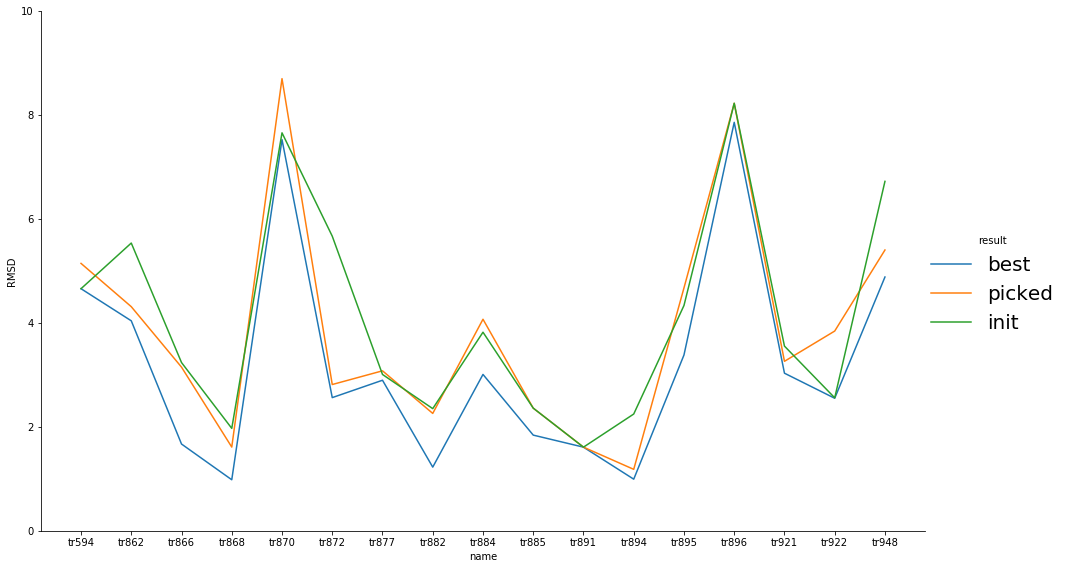

In [101]:
# FEATURES = ["eigenvalues", "entropy", "pca"]
# FEATURES = ["eigenvalues", "entropy", "diffRMSD"]
# FEATURES = ["eigenvalues", "entropy"]
FEATURES = [
    "biasQ",
    'Rw',
     'VTotal',
#     'RMSD', # test
#      'Burial',
#      'Water',
#      'Rama',
#      'DSSP',
#      'P_AP',
#      'Helix',
#      'Frag_Mem'
               ]
# FEATURES = ["eigenvalues"]
# LABEL = "diffRMSD"
# LABEL = "RMSD"
LABEL = "chosen"
DEGREE = 1

def pred_from_raw(a):
    data = my_transform(a, label=LABEL, degree=DEGREE, FEATURES=FEATURES)
    test_y = data[:,-1]
    test_set = data[:,:-1]
    prob= clf.predict_proba(test_set)[:,1]
    return a.assign(prob=prob)

# data = my_transform(raw_data, label=LABEL, degree=DEGREE, FEATURES=FEATURES)
# data = raw_data.groupby('name').apply(my_transform, label=LABEL, degree=DEGREE, FEATURES=FEATURES)[0]
data = np.concatenate(raw_data.groupby('name').apply(my_transform, 
                                                     label=LABEL, degree=DEGREE, FEATURES=FEATURES).values)
train_y = data[:,-1]
train_set = data[:,:-1]
from sklearn import svm
p = 0.5
# clf = svm.SVC(probability=True)
clf = LogisticRegression(random_state=27)
clf.fit(train_set, train_y)

filtered = filtered.reset_index(drop=True).groupby("name").apply(pred_from_raw).reset_index(drop=True)


picked_n = 1
best = raw_data_all_2.groupby("name").apply(choose_top, col="RMSD"
                                            , n=1, ascending=True).reset_index(drop=True).query("chosen==True")
picked = filtered.groupby("name").apply(choose_top, col="prob"
                                            , n=1, ascending=False).reset_index(drop=True).query("chosen==True")
worst = filtered.groupby("name").apply(choose_top, col="RMSD"
                                            , n=1, ascending=False).reset_index(drop=True).query("chosen==True")
init = raw_data_all_2.groupby("name").apply(choose_top, col="i"
                                            , n=1, ascending=True).reset_index(drop=True).query("chosen==True")
all_results = pd.concat([best.assign(result='best'), 
                         picked.assign(result='picked'), init.assign(result='init')
#                         , worst.assign(result='worst')
                        ])
# all_results = pd.concat([best.assign(result='best'), 
#                          picked.assign(result='picked')])
# picked.to_csv("/Users/weilu/Desktop/picked.csv

# sns.set(rc={'figure.figsize':(20,30)})
# plt.figure(figsize=(15,8))
fg = sns.FacetGrid(data=all_results.reset_index(), hue='result', height=8, aspect=1.63)
fg.map(plt.plot, 'name', 'RMSD').add_legend(fontsize=20)
fg.set(ylim=(0, 10))

In [111]:
picked["init_RMSD"] = init["RMSD"].values

In [113]:
picked["diff_RMSD"] = init["RMSD"].values - picked["RMSD"].values

In [119]:
out = picked[["name", "RMSD", "init_RMSD", "diff_RMSD", "folder"]].reset_index(drop=True)

In [121]:
out.to_csv("/Users/weilu/Desktop/picked_3.csv")

In [96]:
clf.coef_

array([[ 0.20157408, -0.69485223,  0.04456798]])

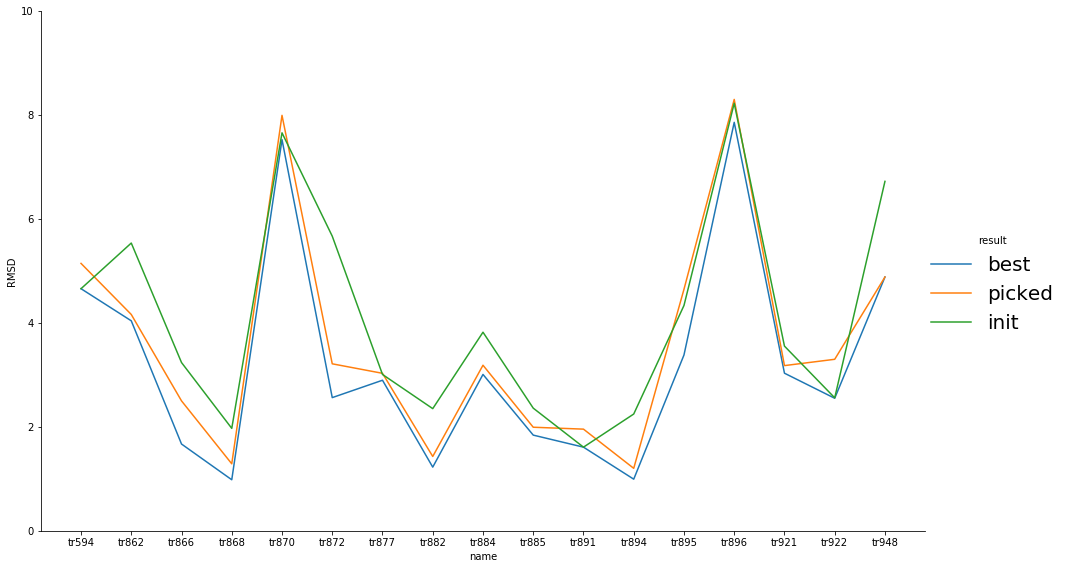

In [63]:
fg = sns.FacetGrid(data=all_results.reset_index(), hue='result', height=8, aspect=1.63)
fg.map(plt.plot, 'name', 'RMSD').add_legend(fontsize=20)
fg.set(ylim=(0, 10))

In [19]:
filtered["name"].unique().shape

(17,)

In [20]:
picked[["RMSD", "name"]]

,RMSD,name
969,7.02078,tr594
1848,5.61065,tr862
3276,2.91322,tr866
4497,1.06823,tr868
6098,8.09616,tr870
6481,4.10102,tr872
8201,3.07719,tr877
9164,2.25775,tr882
10670,3.23479,tr884
11696,2.35937,tr885


In [66]:
picked.to_csv("/Users/weilu/Desktop/picked_2.csv")